In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import acquire
import datatile
import wrangle
from sklearn.model_selection import train_test_split, GridSearchCV

import pandas as pd
import env
import acquire

from scipy import stats
from yellowbrick.features import JointPlotVisualizer
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import PredictionError
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import math


In [68]:
df = acquire.get_zillow_all() 

Reading from csv file...


In [69]:
df.shape

(52319, 68)

In [70]:
df.isnull().sum()

id                              0
parcelid                        0
airconditioningtypeid       38704
architecturalstyletypeid    52249
basementsqft                52272
                            ...  
buildingclassdesc           52319
heatingorsystemdesc         18470
propertylandusedesc             0
storydesc                   52272
typeconstructiondesc        52243
Length: 68, dtype: int64

In [71]:
df.columns

Index(['id', 'parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardb

In [72]:
df_prep = df.copy(deep=True)

In [73]:
0/1

0.0

In [74]:
def wrangle_zillow(df_prep):
    """
    Converts NaN values in bathroom/bedrooms/pool,pool w/hot tube/spa, has spa/hot tub to value 0, replace
    air & heating with correct values and impute with NaN to most frequent value, drop top four outliers in taxvalue,
    drops rows with NaN values, convert fips code to county and rename column to county, rename all columns for readablity,
    splits data using sklean.train_test_split. 
    

    Returns:
    train, validat, test
    
    """
    # Since there is not a good way to calulate missing values regarding bedrooms & bathrooms and there are
    # only 137 values total I will be converting them to np.NaN using the replace function.
    bed_bath_0_columns = ['bedroomcnt', 'bathroomcnt']
    df_prep[bed_bath_0_columns] = df_prep[bed_bath_0_columns].replace(0, np.NaN)
    df_prep = df_prep.reset_index(drop=True)
    # The NaN values in fireplaces, num_pool, pool_w_spa_or_hottub, has_hottub_or_spa, and garage_cars are mostly 0 will be   
    # using the replace function and replacing the NaN values. 
    fire_garge_pool_0_columns = ['poolcnt','pooltypeid2','hashottuborspa', 'fireplacecnt','garagecarcnt', 
                                'threequarterbathnbr', 'garagetotalsqft', 'taxdelinquencyflag', 'basementsqft',
                                'poolsizesum', 'pooltypeid10']
    df_prep[fire_garge_pool_0_columns] = df_prep[fire_garge_pool_0_columns].replace(np.NaN, 0)
    df_prep = df_prep.reset_index(drop=True)

    # replace value 5 with 0 since 5 = no a/c replace value 13 with 1 since 13 = a/c yes
    df_prep.airconditioningtypeid.replace(5, 0, inplace=True) # No AC   
    df_prep.airconditioningtypeid.replace(13, 1, inplace=True) # Central AC

    # replace value 13 with 0 since 13 = no heating and replace NaN with most frequent value
    df_prep.heatingorsystemtypeid.replace(13, 0, inplace=True) # no heat
    df_prep.heatingorsystemtypeid.replace(np.NaN, 2, inplace=True) # replace nan with 2 most frequent value 

    # replace NaN value with most frequent value 1
    df_prep.airconditioningtypeid.replace(np.NaN, 1, inplace=True) # Central AC    

    # drop columns 
    df_prep = df_prep.drop(columns=['calculatedbathnbr', 'finishedfloor1squarefeet','finishedsquarefeet12', 
                                    'regionidcity', 'landtaxvaluedollarcnt', 'taxamount', 'rawcensustractandblock',
                                    'architecturalstyletypeid', 'buildingclasstypeid', 'decktypeid','finishedsquarefeet13',
                                    'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'pooltypeid7',
                                    'storytypeid', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'fireplaceflag',
                                    'airconditioningdesc', 'propertyzoningdesc', 'regionidneighborhood', 'taxdelinquencyyear','architecturalstyledesc',
                                    'buildingclassdesc','heatingorsystemdesc', 'storydesc', 'typeconstructiondesc', 'numberofstories', 'unitcnt'])

    # to make it easier to read and improve visualization I will be renameing the columns using the rename function
    df_prep = df_prep.rename(columns={'bedroomcnt':'bedrooms', 'bathroomcnt':'bathrooms', 'calculatedfinishedsquarefeet':'sqft_living',
    'poolcnt':'num_pools', 'pooltypeid2':'pool_w_spa_or_hottub','hashottuborspa':'has_hottub_or_spa' ,'fireplacecnt':'fireplaces', 
    'garagecarcnt':'garage_cars', 'airconditioningtypeid':'ac_type','heatingorsystemtypeid':'heating_type' ,'yearbuilt':'year_built', 'lotsizesquarefeet':'sqft_lot', 
    'latitude':'lat', 'longitude':'long', 'regionidcounty':'countyid', 'regionidzip':'zip', 'fips':'fips','taxvaluedollarcnt': 'taxvalue'}
    )

    df_prep['buildingqualitytypeid'] = df_prep.buildingqualitytypeid.replace(np.NaN, df_prep.buildingqualitytypeid.mean())

    # drop all rows with NaN values
    df_prep = df_prep.dropna(axis=0)
    df_prep = df_prep.reset_index(drop=True)

    # drop the top 4 upper outliers in taxvalue
    #df_prep.drop([2874,8881,11695,6787], axis=0, inplace=True)

    # convert fips to county 
    #df_prep['fips'] = df_prep['fips'].replace(6111.0, 'Ventura, CA')
    #df_prep['fips'] = df_prep['fips'].replace(6059.0, 'Orange, CA')
    #df_prep['fips'] = df_prep['fips'].replace(6037.0, 'Los Angeles, CA')

    # drop countyid & long/lat columns
    df_prep.drop(columns=['countyid'], inplace=True)
    df_prep.drop(columns=['long'], inplace=True)
    df_prep.drop(columns=['lat'], inplace=True)

    # rename fips to county
    #df_prep = df_prep.rename(columns={'fips':'county'})

    #change categorical features to categorical dtype
        
    return df_prep
    

In [75]:
df_prep=wrangle_zillow(df_prep)

In [76]:
df_prep.shape

(51644, 34)

In [77]:
train_validate, test = train_test_split(df_prep, test_size=0.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=0.3, random_state=123)

In [78]:
train.columns

Index(['id', 'parcelid', 'ac_type', 'basementsqft', 'bathrooms', 'bedrooms',
       'buildingqualitytypeid', 'sqft_living', 'fips', 'fireplaces',
       'fullbathcnt', 'garage_cars', 'garagetotalsqft', 'has_hottub_or_spa',
       'heating_type', 'sqft_lot', 'num_pools', 'poolsizesum', 'pooltypeid10',
       'pool_w_spa_or_hottub', 'propertycountylandusecode',
       'propertylandusetypeid', 'zip', 'roomcnt', 'threequarterbathnbr',
       'year_built', 'structuretaxvaluedollarcnt', 'taxvalue',
       'assessmentyear', 'taxdelinquencyflag', 'censustractandblock',
       'logerror', 'transactiondate', 'propertylandusedesc'],
      dtype='object')

In [80]:
train.columns

Index(['id', 'parcelid', 'ac_type', 'basementsqft', 'bathrooms', 'bedrooms',
       'buildingqualitytypeid', 'sqft_living', 'fips', 'fireplaces',
       'fullbathcnt', 'garage_cars', 'garagetotalsqft', 'has_hottub_or_spa',
       'heating_type', 'sqft_lot', 'num_pools', 'poolsizesum', 'pooltypeid10',
       'pool_w_spa_or_hottub', 'propertycountylandusecode',
       'propertylandusetypeid', 'zip', 'roomcnt', 'threequarterbathnbr',
       'year_built', 'structuretaxvaluedollarcnt', 'taxvalue',
       'assessmentyear', 'taxdelinquencyflag', 'censustractandblock',
       'logerror', 'transactiondate', 'propertylandusedesc'],
      dtype='object')

# Is there a corr. between logerror and year built?

# HO: No linear difference between logerror for properties in year built
# H1: linear difference in logerror for properties in year built

Alpha 0.05

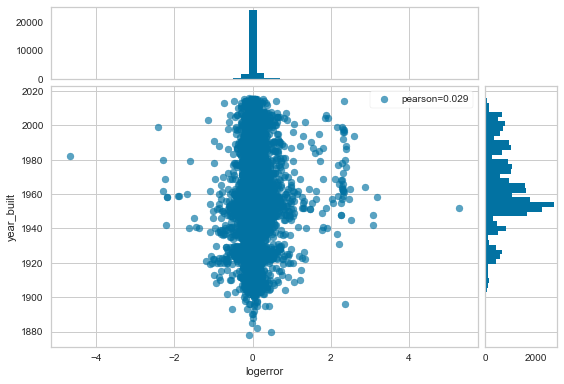

r = 0.0285, p = 0.0000


In [94]:
# Visualize using yellowbrick library & statsmodels
visualizer = JointPlotVisualizer(columns=['logerror', 'year_built'], line_kws={'color': 'red'})
visualizer.fit_transform(train)
visualizer.show()
r, p = stats.pearsonr(train.year_built, train.logerror)
print(f'r = {r:.4f}, p = {p:.4f}')

# H0 = 'No significant difference in logerror for properties in LA County vs Orange County vs Ventura County'
# H1 = 'Significant difference in logerror for properties in LA County vs Orange County vs Ventura County'

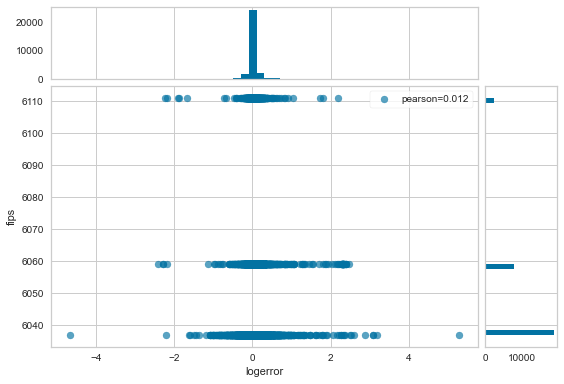

r = 0.0122, p = 0.0378


In [95]:
# Visualize using yellowbrick library & statsmodels
visualizer = JointPlotVisualizer(columns=['logerror', 'fips'], line_kws={'color': 'red'})
visualizer.fit_transform(train)
visualizer.show()
r, p = stats.pearsonr(train.fips, train.logerror)
print(f'r = {r:.4f}, p = {p:.4f}')

# ANOVA

In [101]:
α = 0.05
F, p = stats.f_oneway(train.logerror[train.fips == 6111], train.logerror[train.fips == 6037], train.logerror[train.fips == 6059])
F, p



(18.197980279417205, 1.2638254279814151e-08)

In [98]:
null_hypothesis = 'No significant difference in logerror for properties in LA County vs Orange County vs Ventura County'

if p > α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We reject the null hypothesis that No significant difference in logerror for properties in LA County vs Orange County vs Ventura County


In [99]:
fips1 = train[train.fips == train.fips.unique()[0]]
fips2 = train[train.fips == train.fips.unique()[1]]
fips3 = train[train.fips == train.fips.unique()[2]]
stat, p
alpha = .05
stat, p = stats.levene(fips1.logerror, fips2.logerror, fips3.logerror)
if p < alpha:
    print('equal variances')
else: print('unequal variances')
stat, p

equal variances


(20.26970203787779, 1.5964123229062909e-09)

In [ ]:
for i, fips_c in enumerate(train.fips.unique()):
    fips = train[train.fips == fips_c]
    sns.histplot(fips.logerror)
    plt.show()